In [ ]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
df = pd.read_excel('ukrainian_migration_to_poland_data.xlsx')
df['date'] = pd.to_datetime(df['date'])
df['simple sentiment'] = df['simple sentiment'].str.lower().str.strip()
df = df.dropna(subset=['simple sentiment'])

In [148]:
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             1309 non-null   object        
 1   text              672 non-null    object        
 2   subreddit         1314 non-null   object        
 3   date              1314 non-null   datetime64[ns]
 4   url               1314 non-null   object        
 5   combined text     1314 non-null   object        
 6   combined text en  1314 non-null   object        
 7   sia sentiment     1314 non-null   object        
 8   simple sentiment  1314 non-null   object        
 9   month             1314 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(8)
memory usage: 102.8+ KB


In [150]:
# Count sentiment per month/subreddit
sentiment_counts = (
    df.groupby(['month', 'subreddit', 'simple sentiment'])
      .size()
      .reset_index(name='count')
)

In [151]:
# Color scheme
color_scale = alt.Scale(
    domain=['positive', 'neutral', 'negative'],
    range=['#4CAF50', '#FFC107', '#F44336'] 
)

In [152]:
# Create base chart
def make_chart(subreddit_name):
    chart = alt.Chart(sentiment_counts[sentiment_counts['subreddit'] == subreddit_name]).mark_line(point=True).encode(
        x=alt.X('month:T', title='Month'),
        y=alt.Y('count:Q', title='Number of Posts'),
        color=alt.Color('simple sentiment:N', scale=color_scale, title='Sentiment'),
        tooltip=['month', 'simple sentiment', 'count']
    ).properties(
        width=450,
        height=400,
        title=f"Sentiment Over Time – r/{subreddit_name}"
    )
    return chart

In [153]:
# Side-by-side charts
final_chart = alt.hconcat(
    make_chart('poland'),
    make_chart('Polska')
).resolve_scale(
    y='shared'
)

In [154]:
final_chart

alt.HConcatChart(...)

In [155]:
poland_counts = sentiment_counts[sentiment_counts['subreddit'] == 'poland'].copy()

In [156]:
poland_counts['month_str'] = poland_counts['month'].dt.strftime('%Y-%m')

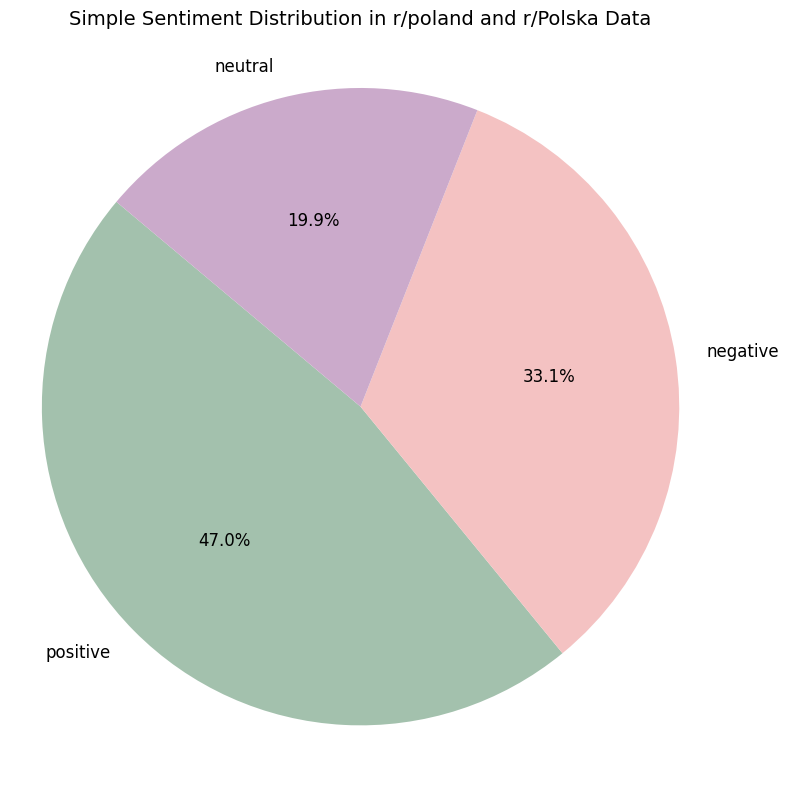

In [162]:
# Count the sentiment values
sentiment_counts = df['simple sentiment'].value_counts()

# Define nicer, thesis-appropriate pastel colors
colors = ['#A3C1AD', '#F4C2C2', '#CBAACB']  # You can adjust or expand this list

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title('Simple Sentiment Distribution in r/poland and r/Polska Data', fontsize=14)
plt.axis('equal')  # Ensures pie is a perfect circle
plt.tight_layout()
plt.show()

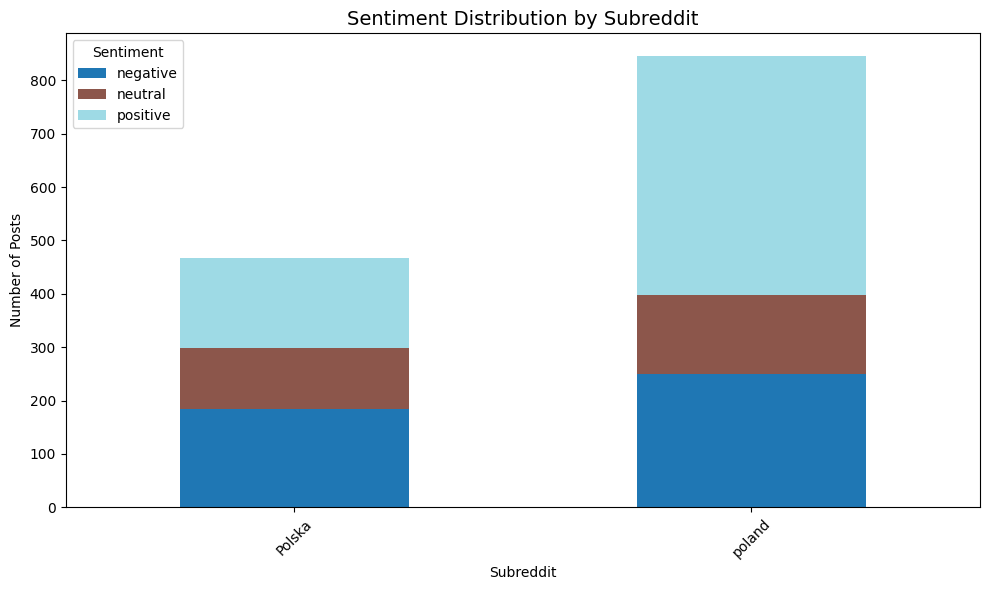

In [222]:
# Group by subreddit and sentiment
sentiment_by_sub = df.groupby(['subreddit', 'simple sentiment']).size().unstack().fillna(0)

# Plot
sentiment_by_sub.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Sentiment Distribution by Subreddit', fontsize=14)
plt.ylabel('Number of Posts')
plt.xlabel('Subreddit')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

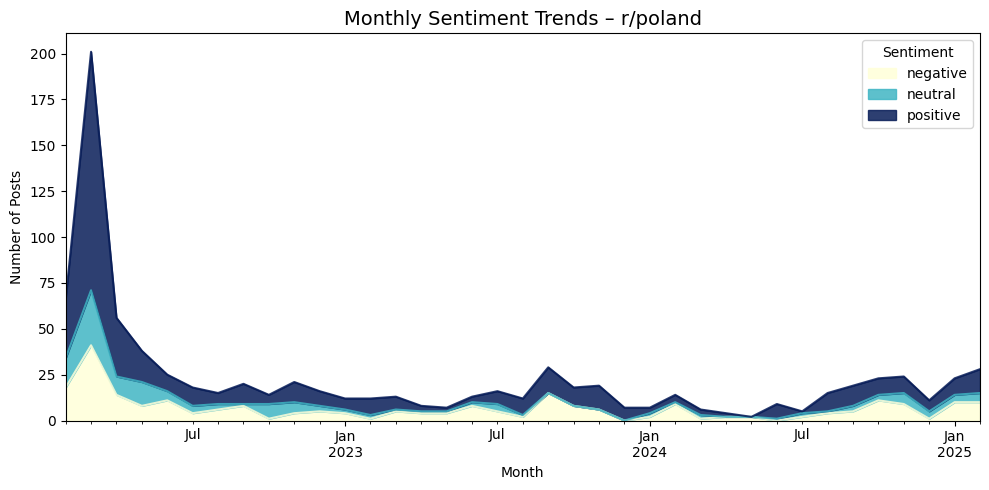

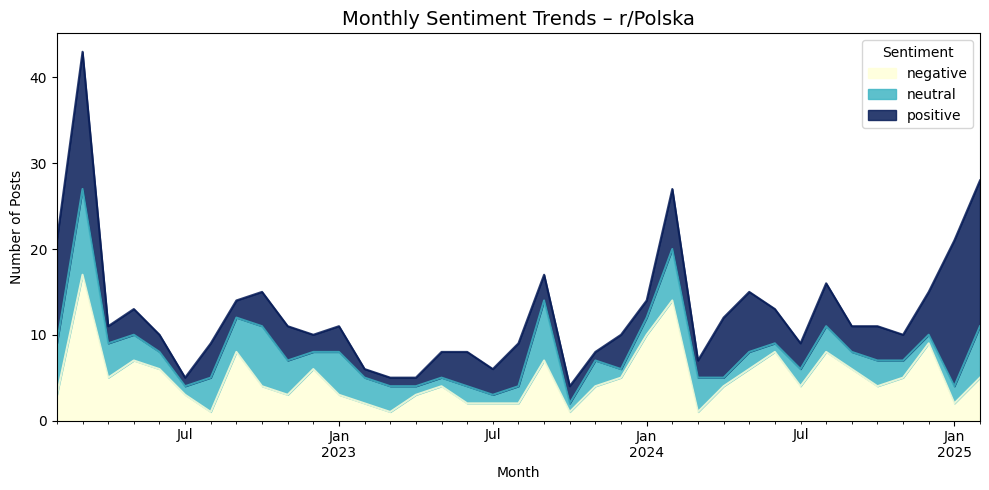

In [211]:
# Only convert to timestamp for plotting
df['month_ts'] = df['month'].dt.to_timestamp()

# Group by actual month (period), subreddit, and sentiment
monthly_sent = df.groupby([df['month'], 'subreddit', 'simple sentiment']).size().reset_index(name='count')

# Convert the month Period to datetime for plotting
monthly_sent['month'] = monthly_sent['month'].dt.to_timestamp()

# Plot one area chart per subreddit
subreddits = df['subreddit'].unique()

for sub in subreddits:
    sub_df = monthly_sent[monthly_sent['subreddit'] == sub]
    pivot = sub_df.pivot(index='month', columns='simple sentiment', values='count').fillna(0)
    
    pivot.plot.area(figsize=(10, 5), alpha=0.85, colormap='YlGnBu')
    plt.title(f'Monthly Sentiment Trends – r/{sub}', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Number of Posts')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()


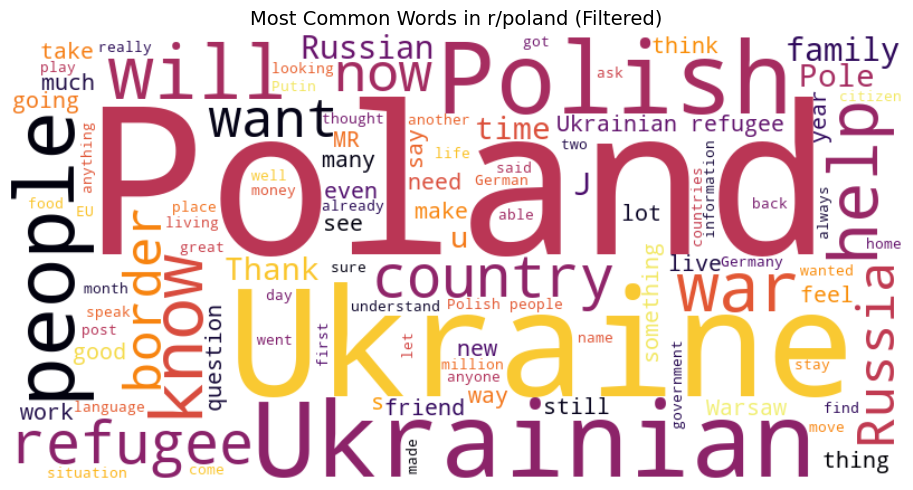

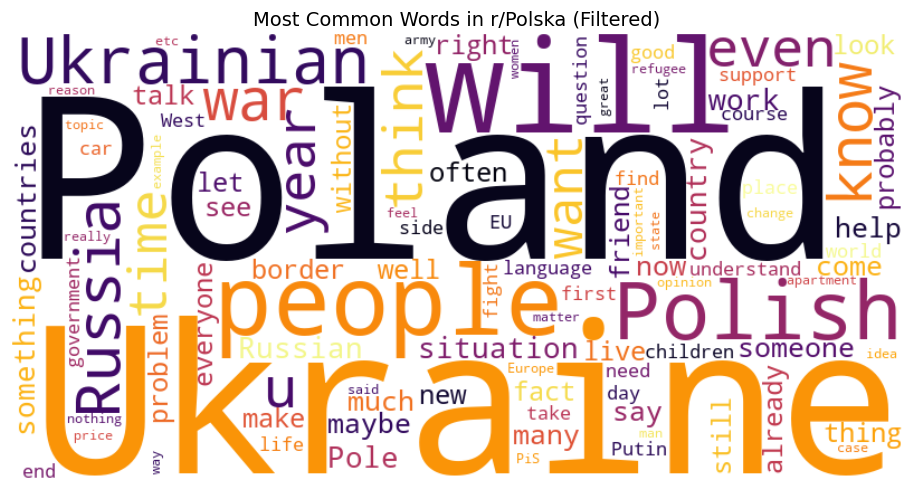

In [184]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# You can add extra words you want to ignore
custom_stopwords = set(STOPWORDS).union({'https', 'www', 'com', 'like', 'would', 'one', 'also', 'get', 'go'})

subreddits = df['subreddit'].unique()

for sub in subreddits:
    text_data = df[df['subreddit'] == sub]['combined text en'].dropna()
    text = ' '.join(text_data)

    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='inferno',
        stopwords=custom_stopwords,
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in r/{sub} (Filtered)', fontsize=14)
    plt.tight_layout()
    plt.show()